In [2]:
from IPython.display import clear_output
import sys
if 'google.colab' in sys.modules:
  !pip install category_encoders==2.*
  !pip install pandas-profiling==2.*
  !pip install plotly==4.*

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline

plt.style.use('fivethirtyeight')


import nltk
from nltk.corpus import wordnet as wn

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

!pip install pdpbox
!pip install shap

import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

clear_output()

In [6]:
from google.colab import files
myfiles = files.upload()

Saving titles.csv to titles.csv


## # M1 local환경에서 shap이 설치되지 않아서 pdp, shap결과는 colab에서 작성

In [11]:
df = pd.read_csv('shap_on_colab.csv', index_col=0)
df.drop(columns='title', inplace=True)
df.head(2).T

,0,1
original_language,en,en
popularity,3.13318,2.89123
runtime,81,104
vote_count,8.59711,7.78904
genres_tmdb_complexity,3,3
collection,Toy Story Collection,none_collection
main_production_companies,Pixar Animation Studios,TriStar Pictures
main_production_countries,United States of America,United States of America
year,1995,1995
budget,17.2167,17.9899


In [17]:
df_origin = pd.read_csv('titles.csv',index_col=0)
df_origin.head()

,original_title,imdbId,Producer
0,Toy Story,114709,John Lasseter
1,Jumanji,113497,Larry J. Franco
2,Grumpier Old Men,113228,Howard Deutch
3,Waiting to Exhale,114885,Forest Whitaker
4,Father of the Bride Part II,113041,Alan Silvestri


In [12]:
def split_X_y(x, target):
  y = x[target]
  x = x.drop(columns=[target]) 
  return x, y
  
def printshape(*args):
  [print(i.shape) for i in args]

train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=42)

target = 'rating'

# train = engineer(train)
# val = engineer(val)
# test = engineer(test)

X_train, y_train = split_X_y(train, target)
X_val, y_val = split_X_y(val, target)
X_test, y_test = split_X_y(test, target)
printshape(X_train, y_train, X_val, y_val, X_test, y_test)

(28703, 25)
(28703,)
(7176, 25)
(7176,)
(8970, 25)
(8970,)


# 0) RandomForest
- 동일한 hyperparameter로 재학습


In [ ]:
from category_encoders import TargetEncoder

pipe = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(min_samples_leaf= 38
                                                 ,smoothing= 2.0)
                                    ,SimpleImputer()
                                   )),
    ('rf', RandomForestRegressor(n_jobs=-1
                                , random_state=42
                                , oob_score=True
                                , max_depth=20
                                 , max_features=0.9782948245641648
                                 , n_estimators=1000
                                 , min_samples_leaf=17
                                 )) ]
)

pipe.fit(X_train, y_train)

In [16]:
from sklearn.metrics import mean_squared_log_error
print(f'train set : {pipe.score(X_train,y_train)}')
print(f'val set : {pipe.score(X_val,y_val)}')

X_val_tranformed = pipe.named_steps['preprocessing'].transform(X_val)
model = pipe.named_steps['rf']
y_pred = model.predict(X_val_tranformed)
msle = mean_squared_log_error(y_val, y_pred)**0.5
mae = mean_absolute_error(y_val, y_pred)
print(f'val MSLE:{msle}, MAE: {mae}')

train set : 0.42558285484923153
val set : 0.23406790788688295
val MSLE:0.17720396746855238, MAE: 0.43689987772433503


# 1) PDP

In [ ]:
plt.rcParams['figure.dpi'] = 144

In [ ]:
# popularity                   0.008251
# Producer                     0.014466
# actor_1_name                 0.017349
# genre_by_similar             0.026732
# vote_count


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


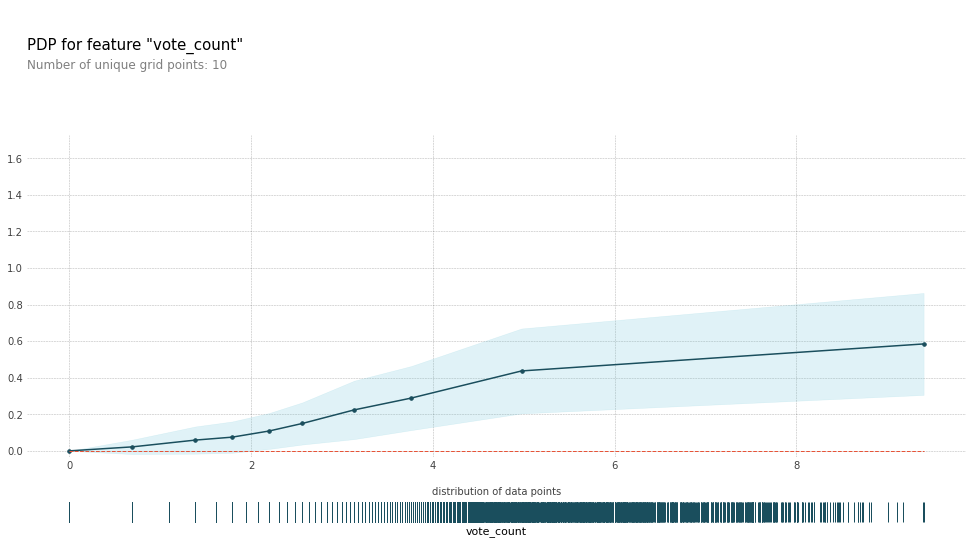

In [18]:
feature = 'vote_count'

isolated = pdp_isolate(
    model=model, 
    dataset=pd.DataFrame(X_val_tranformed, columns=X_val.columns, index=X_val.index), 
    model_features=pd.DataFrame(X_val_tranformed, columns=X_val.columns, index=X_val.index).columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated
         , feature_name=feature
#          , plot_lines=True # ICE plots
#          , frac_to_plot=100 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


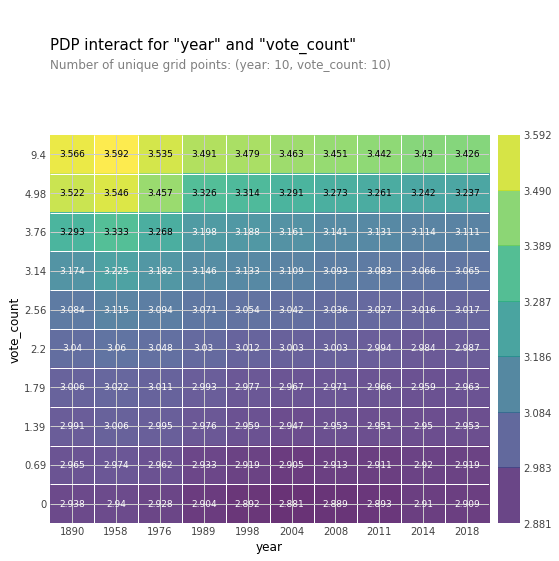

In [20]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['year', 'vote_count']

interaction = pdp_interact(
    model=model, 
    dataset=pd.DataFrame(X_val_tranformed, columns=X_val.columns, index=X_val.index),
    model_features=pd.DataFrame(X_val_tranformed, columns=X_val.columns, index=X_val.index).columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


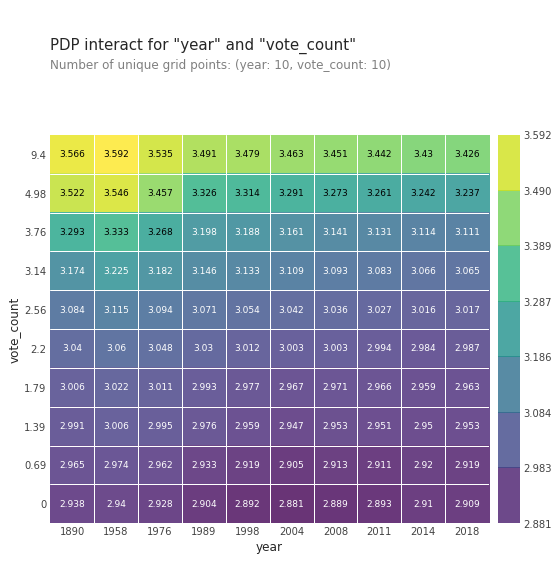

In [21]:
sns.set_style("white")
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [22]:
# 위에서 만든 2D PDP를 테이블로 변환(using Pandas, df.pivot_table)하여 사용합니다

pdp = interaction.pdp.pivot_table(
    values='preds', # interaction['preds']
    columns=features[0], 
    index=features[1]
    )[::-1] # 인덱스를 역순으로 만드는 slicing입니다
pdp

year,1890.0,1958.0,1976.0,1989.0,1998.0,2004.0,2008.0,2011.0,2014.0,2018.0
vote_count,,,,,,,,,,
9.402200,3.566383,3.591921,3.535125,3.490826,3.479442,3.462847,3.450720,3.442117,3.429731,3.426480
4.976734,3.521548,3.546080,3.457447,3.326393,3.313926,3.291193,3.273264,3.260971,3.242481,3.237319
3.761200,3.293136,3.332863,3.267956,3.198319,3.187515,3.161489,3.141457,3.131312,3.114332,3.110946
3.135494,3.174325,3.224517,3.181775,3.145560,3.132842,3.109020,3.092964,3.082690,3.066492,3.065113
2.564949,3.084224,3.114646,3.094478,3.071067,3.054213,3.042436,3.036473,3.027472,3.015682,3.016553
2.197225,3.040456,3.059940,3.048277,3.029696,3.011789,3.003132,3.002784,2.994425,2.983616,2.986665
1.791759,3.005994,3.022095,3.010999,2.993110,2.977240,2.967410,2.970640,2.965620,2.959014,2.963095
1.386294,2.990852,3.005664,2.995053,2.975585,2.958920,2.947220,2.953322,2.951023,2.949730,2.952997
0.693147,2.964828,2.973984,2.961539,2.932981,2.918761,2.904828,2.912594,2.910511,2.920052,2.918618


In [23]:

import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

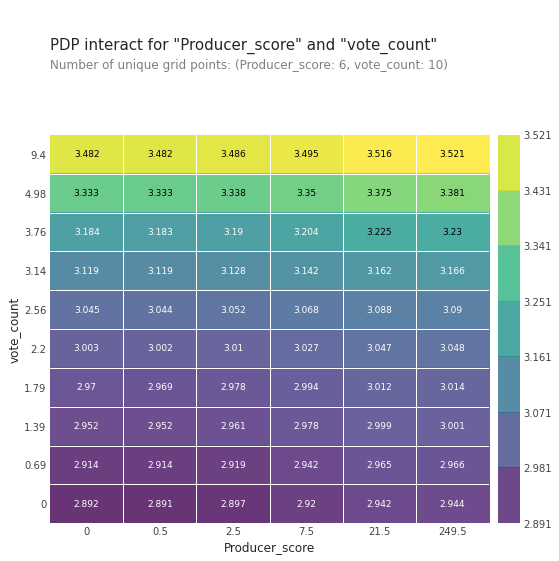

In [25]:
features = ['Producer_score', 'vote_count']

interaction = pdp_interact(
    model=model, 
    dataset=pd.DataFrame(X_val_tranformed, columns=X_val.columns, index=X_val.index),
    model_features=pd.DataFrame(X_val_tranformed, columns=X_val.columns, index=X_val.index).columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [41]:
X_val_vis = pd.DataFrame(X_val_tranformed, columns=X_val.columns, index=X_val.index)

In [67]:
X_train_tranformed = pipe.named_steps['preprocessing'].transform(X_train)

In [70]:
X_train_vis = pd.DataFrame(X_train_tranformed, columns=X_train.columns, index=X_train.index)

In [71]:
X_train_vis.loc[X_train_vis['genre_by_similar']==3.079795]

,original_language,popularity,runtime,vote_count,genres_tmdb_complexity,collection,main_production_companies,main_production_countries,year,budget,gross_world,incomes,actor_1_name,actor_2_name,actor_3_name,n_crew,Producer,Producer_score,genre_by_similar,gender_ratio,actor_1_score,actor_2_score,actor_3_score,imputed_genre_similarity,actor_power


In [72]:
X_train_vis['genre_by_similar']

21423    3.006022
14658    3.121338
30925    3.121338
4002     2.990927
32476    2.907839
           ...   
31231    3.121338
24928    3.181696
23248    3.271088
8621     3.086165
11727    3.208979
Name: genre_by_similar, Length: 28703, dtype: float64

In [73]:
encoder = pipe.named_steps['preprocessing']['targetencoder']
encoder.mapping['genre_by_similar']

genre_by_similar
 1      3.006022
 2      3.121338
 3      2.990927
 4      2.907839
 5      2.970911
          ...   
 198    3.079795
 199    3.079795
 200    3.079795
-1      3.079795
-2      3.079795
Length: 202, dtype: float64

In [52]:
# target encoder mapping은 1) ordinal encoder mapping 된 다음에 
# ordinal encoding 숫자에 target 값을 mapping
category_target = encoder.mapping['genre_by_similar']
category_target

genre_by_similar
 1      3.006022
 2      3.121338
 3      2.990927
 4      2.907839
 5      2.970911
          ...   
 198    3.079795
 199    3.079795
 200    3.079795
-1      3.079795
-2      3.079795
Length: 202, dtype: float64

In [78]:
encoder.ordinal_encoder.mapping['col']=='genre_by_similar'

TypeError: ignored

In [40]:
feature = 'genre_by_similar'
for item in encoder.ordinal_encoder.mapping:
  if item['col'] == feature:
    print(item['mapping'])
    feature_mapping = item['mapping'] # Series

NaN                   1
Crime|Thriller        2
Adventure|Comedy      3
Fantasy|Thriller      4
Animation|Family      5
                   ... 
Animation|Crime     196
Family|Mystery      197
Adventure|Music     198
Music|Mystery       199
Family|History      200
Length: 200, dtype: int64


In [55]:
feature_mapping.values

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

# 2) Shap

In [ ]:
df_p.head()

,tmdbID,original_language,original_title,popularity,runtime,spoken_languages,status,vote_average,vote_count,imdbId,genres_tmdb,genres_tmdb_complexity,collection,n_production_companies,main_production_companies,n_production_countries,main_production_countries,year,month,budget,gross_world,incomes,movieId,tmdbId,rating,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender,n_crew,Producer,Producer_score,actor_1_won,actor_1_nominat,actor_2_won,actor_2_nominat,actor_3_won,actor_3_nominat,genre_similarity,genre_by_similar,gender_ratio
0,862,en,Toy Story,3.133,81.000,1,Released,7.700,8.597,0114709,Animation|Comedy|Family,3,Toy Story Collection,1,Pixar Animation Studios,1,United States of America,1995.000,10.000,17.217,19.739,2.599,1.000,862,3.887,Tom Hanks,Tim Allen,Don Rickles,2.000,2.000,2.000,106.000,John Lasseter,50.500,52.000,118.000,10.000,10.000,7.000,2.000,0.091,Comedy|Family,6.000
1,8844,en,Jumanji,2.891,104.000,2,Released,6.900,7.789,0113497,Adventure|Fantasy|Family,3,none_collection,3,TriStar Pictures,1,United States of America,1995.000,12.000,17.990,19.387,1.618,2.000,8844,3.247,Robin Williams,Jonathan Hyde,Kirsten Dunst,2.000,2.000,1.000,16.000,Larry J. Franco,0.000,26.000,56.000,1.000,0.000,27.000,70.000,0.083,Family|Fantasy,5.000
2,15602,en,Grumpier Old Men,2.543,101.000,1,Released,6.500,4.533,0113228,Romance|Comedy,2,Grumpy Old Men Collection,2,Warner Bros.,1,United States of America,1995.000,12.000,17.034,18.085,1.351,3.000,15602,3.174,Walter Matthau,Jack Lemmon,Ann-Margret,2.000,2.000,1.000,4.000,Howard Deutch,1.500,13.000,20.000,25.000,55.000,22.000,57.000,0.091,Comedy|Romance,5.000
3,31357,en,Waiting to Exhale,1.581,127.000,1,Released,6.100,3.555,0114885,Comedy|Drama|Romance,3,none_collection,1,Twentieth Century Fox Film Corporation,1,United States of America,1995.000,12.000,16.588,18.216,1.807,4.000,31357,2.875,Whitney Houston,Angela Bassett,Loretta Devine,1.000,1.000,1.000,10.000,Forest Whitaker,78.500,263.000,218.000,20.000,74.000,4.000,16.000,0.077,Drama|Romance,3.000
4,11862,en,Father of the Bride Part II,2.239,106.000,1,Released,5.700,5.159,0113041,Comedy,1,Father of the Bride Collection,2,etc,1,United States of America,1995.000,2.000,17.217,18.154,1.268,5.000,11862,3.077,Steve Martin,Diane Keaton,Martin Short,2.000,1.000,2.000,7.000,Alan Silvestri,0.000,22.000,48.000,28.000,69.000,8.000,29.000,1.000,Comedy,5.000


#### validation set에서 모델이 예측한 top 5 movie

In [95]:
X_val_pred = pd.Series(model.predict(X_val_tranformed), index=X_val.index)
X_val_pred.sort_values(ascending=False)[:5]

6505    3.928975
2621    3.926064
887     3.924956
901     3.918458
898     3.909963
dtype: float64

In [98]:
n_movie = 898
print(df_origin.loc[X_val_vis.iloc[[n_movie]].index])
X_val_vis.iloc[[n_movie]]

           original_title   imdbId      Producer
31983  I Am Steve McQueen  2649194  Jeff Renfroe


,original_language,popularity,runtime,vote_count,genres_tmdb_complexity,collection,main_production_companies,main_production_countries,year,budget,gross_world,incomes,actor_1_name,actor_2_name,actor_3_name,n_crew,Producer,Producer_score,genre_by_similar,gender_ratio,actor_1_score,actor_2_score,actor_3_score,imputed_genre_similarity,actor_power
31983,3.033983,0.617023,90.0,2.079442,1.0,3.091025,3.051891,3.024932,2014.0,15.424949,9.00516,0.272065,3.079795,3.079795,3.079795,2.0,3.079795,7.0,3.414494,5.0,64.5,110.5,0.0,1.0,58.333333


In [99]:
raw = X_val_vis.iloc[[6505]] # [[]]면 dataframe으로 반환, 꿀팁
raw

,original_language,popularity,runtime,vote_count,genres_tmdb_complexity,collection,main_production_companies,main_production_countries,year,budget,gross_world,incomes,actor_1_name,actor_2_name,actor_3_name,n_crew,Producer,Producer_score,genre_by_similar,gender_ratio,actor_1_score,actor_2_score,actor_3_score,imputed_genre_similarity,actor_power
9224,3.231666,2.098897,129.0,5.342334,4.0,3.079795,3.056294,3.162388,2004.0,16.300417,16.821478,0.987239,3.079795,3.079795,3.079795,12.0,3.079795,84.5,3.271088,4.0,50.0,80.0,202.5,0.071429,110.833333


In [102]:
#tree 모델의 예측값
model.predict(raw)

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(raw)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=raw
)

In [103]:
# 300개 테스트 샘플에 대해서 각 특성들의 영향을 봅니다. 샘플 수를 너무 크게 잢으면 계산이 오래걸리니 주의하세요.
shap_values = explainer.shap_values(X_val_vis.iloc[:100])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_val_vis.iloc[:100])

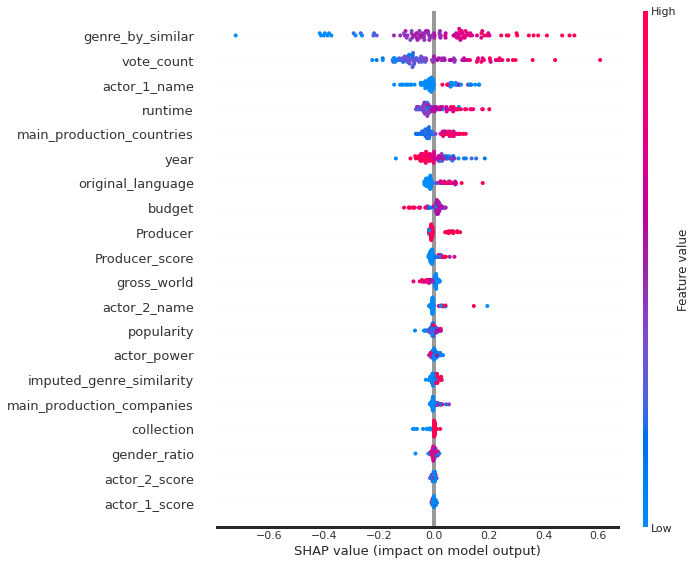

In [104]:
shap.summary_plot(shap_values, X_val_vis.iloc[:100])